<a href="https://colab.research.google.com/github/FabioBoccia/Progetto_ESM/blob/main/Progetto_Bozza_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameters

In [47]:
# Loading
batch_size = 128
interpolation = 'bilinear'

# Preprocessing
window_size = 3

# Setup

In [ ]:
%cd /content
%rm -r sample_data
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ffhq/train/real
!mkdir -p ffhq/train/synthesized
!mkdir -p ffhq/test/real
!mkdir -p ffhq/test/synthesized
!mkdir -p /content/drive/MyDrive/pesi_ffhq

In [2]:
%cd /content
!wget --user=corso --password=p2021corso http://www.grip.unina.it/download/corso/ffhq_real.zip
!unzip -q ffhq_real.zip
%cd /content/0_real/
!mv $(ls | shuf -n 2500) ../ffhq/train/real/
!mv * ../ffhq/test/real/
%cd ..
!rm -d 0_real

Mounted at /content/drive
--2022-05-20 17:06:52--  http://www.grip.unina.it/download/corso/ffhq_real.zip
Resolving www.grip.unina.it (www.grip.unina.it)... 143.225.28.237
Connecting to www.grip.unina.it (www.grip.unina.it)|143.225.28.237|:80... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="corso"
Reusing existing connection to www.grip.unina.it:80.
HTTP request sent, awaiting response... 200 OK
Length: 4072216854 (3.8G) [application/zip]
Saving to: ‘ffhq_real.zip’

ffhq_real.zip       100%[===================>]   3.79G  27.7MB/s    in 2m 48s  

2022-05-20 17:09:41 (23.1 MB/s) - ‘ffhq_real.zip’ saved [4072216854/4072216854]

/content/0_real
/content


In [3]:
%cd /content/drive/MyDrive/samples/generate/
!mkdir -p /content/tmp/
!cp * /content/tmp/
%cd /content/tmp/
!mv $(ls | shuf -n 2500) /content/ffhq/train/synthesized/
!mv * /content/ffhq/test/synthesized/
%cd /content
!rm -r tmp/

/content/drive/MyDrive/samples/generate
/content/tmp
/content


In [4]:
# Necessary dependencies
!pip install tensorflow_io

%reset -f
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

     |████████████████████████████████| 25.9 MB 85.7 MB/s 
     |████████████████████████████████| 2.4 MB 69.9 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.25.0
    Uninstalling tensorflow-io-gcs-filesystem-0.25.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


# Loading

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'ffhq/train/',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle=True,
    seed=125,
    validation_split=1/5, # Validation is 1/6 of the total, so 1/5 of (total - test)
    subset='training',
    interpolation=interpolation,
    crop_to_aspect_ratio=True,
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    'ffhq/train/',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle=True,
    seed=125,
    validation_split=1/5,
    subset='validation',
    interpolation=interpolation,
    crop_to_aspect_ratio=True,
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'ffhq/test/',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle=True,
    seed=125,
    validation_split=0,
    interpolation=interpolation,
    crop_to_aspect_ratio=True,
)
#train_dataset = tf.keras.applications.xception.preprocess_input(train_dataset)
#val_dataset = tf.keras.applications.xception.preprocess_input(val_dataset)
#test_dataset = tf.keras.applications.xception.preprocess_input(test_dataset)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 1000 files belonging to 2 classes.


In [48]:
# Data Augmentation

def randomGaussianBlur(x):
    k = tf.random.uniform(
        shape=[],
        minval=0.0,
        maxval=3.0,
        dtype=tf.float32
    )
    return tfio.experimental.filter.gaussian(x, window_size, k)

def randomRot90(x):
    k = tf.random.uniform(
        shape=[],
        minval=0,
        maxval=4,
        dtype=tf.dtypes.int32,
        seed=None,
        name=None
    )
    return tf.image.rot90(x, k)

def augment(x):
    y = randomGaussianBlur(x)
    y = randomRot90(x)
    return y

train_dataset = train_dataset.map(lambda x, y: (augment(x), y))

In [9]:
# Cache optimizations
# Reference: https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Model definition

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn
# lr *0,1 dopo metà numero totale delle epoche
exponential_decay_fn = exponential_decay(0.001, s=100)
# LEARNING RATE SCHEDULING - EXPONENTIAL DECAY
# lr0 - learning rate iniziale
# s - numero di step
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
''' lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)'''
# eventuale performance scheduler
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

opt = tf.keras.optimizers.Nadam(
    lr=lr_scheduler
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
)
loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction=tf.keras.losses.Reduction.AUTO,
)
metric = tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_2 (CenterCrop)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 17,550,273
Non-trainable params: 3,313,256
__________________________________

In [ ]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='Max',
)
train_after_layer = 50
for layer in base_model.layers[:train_after_layer]:
    layer.trainable = False

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(256,256,3)))
model.add(tf.keras.layers.CenterCrop(224,224))
model.add(tf.keras.layers.Rescaling(1./127.5, offset=-1))
model.add(base_model)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=[metric, 'accuracy',]
)
model.summary()

# Training

In [ ]:
epochs = 2
for i in range(51):
    model.fit(
        train_dataset,
        epochs=(1+i)*epochs,
        initial_epoch=i*epochs,
        verbose="auto",
        #validation_data=val_dataset,
        #validation_freq=1,
        shuffle=True,
        callbacks=[lr_scheduler] # lr scheduling
    )
    loss, AUC, accuracy = model.evaluate(val_dataset)
    model.save_weights('drive/MyDrive/pesi_ffhq/%d_%.3f_%.3f.h5' %((i+1)*epochs, loss, AUC))

# Testing

In [ ]:
loss, AUC, accuracy = model.evaluate(test_dataset)

Found 1000 files belonging to 2 classes.
1000/1000 [==============================] - 30s 28ms/step - loss: 0.0507 - auc_2: 0.9967 - accuracy: 0.9860


# Augmentation Test

In [49]:
example_batch = list(train_dataset.as_numpy_iterator())[3]

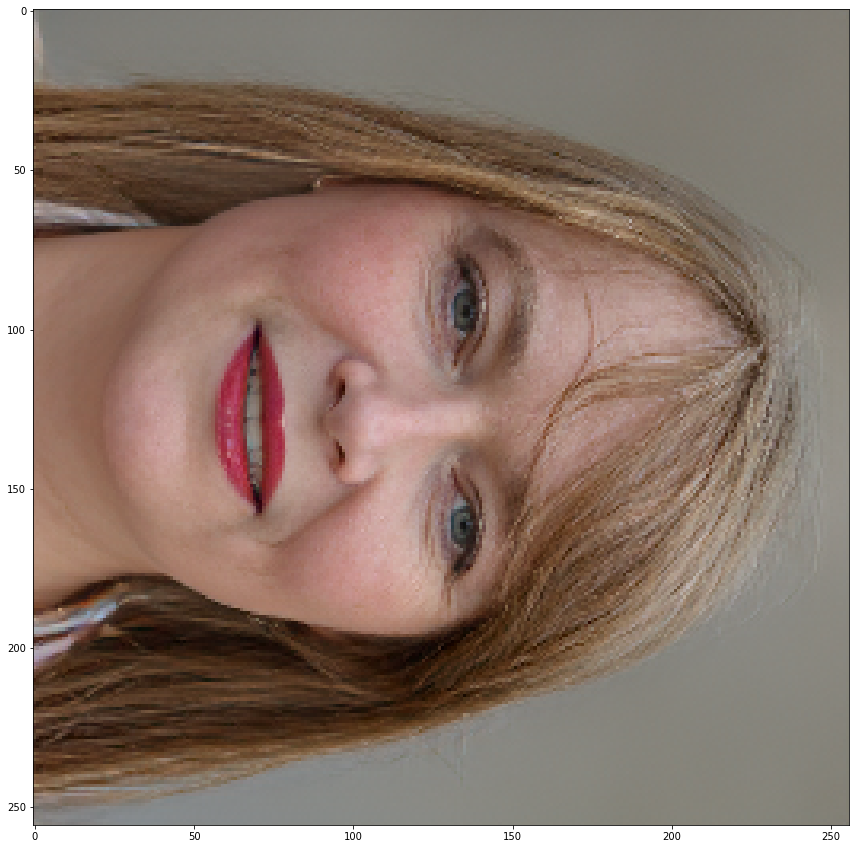

In [52]:
import matplotlib.pyplot as plt
ID = np.random.randint(32)
x = example_batch[0][ID,:,:,:]
x = x / 255
plt.figure(figsize=(15,15))
plt.imshow(x)
plt.show()